In [3]:
#Step 1

# Install necessary libraries
!pip install tensorflow keras matplotlib scikit-learn pandas opencv-python

In [4]:
#Step 2

# Download Food-101 dataset
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar -xvzf food-101.tar.gz


Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/

In [5]:
# Step 3

import os

base_dir = 'food-101'
images_dir = os.path.join(base_dir, 'images')
meta_dir   = os.path.join(base_dir, 'meta')

print("Training Images Folder (first 5 classes):", os.listdir(images_dir)[:5])
print("Meta Folder:", os.listdir(meta_dir))


Training Images Folder (first 5 classes): ['clam_chowder', 'scallops', 'french_fries', 'pork_chop', 'deviled_eggs']
Meta Folder: ['test.txt', 'train.json', 'classes.txt', 'test.json', 'train.txt', 'labels.txt']


In [6]:
# Step 4

import random

def read_lines(path):
    with open(path, 'r') as f:
        return [x.strip() for x in f.readlines()]

classes = read_lines(os.path.join(meta_dir, 'classes.txt'))
class_to_id = {c:i for i,c in enumerate(classes)}
id_to_class = {i:c for c,i in class_to_id.items()}

train_list_all = read_lines(os.path.join(meta_dir, 'train.txt'))  # "class/filename"
test_list      = read_lines(os.path.join(meta_dir, 'test.txt'))

# Create a validation split from official train list (10%)
random.seed(42)
random.shuffle(train_list_all)
val_ratio = 0.10
val_count = int(len(train_list_all) * val_ratio)
val_list  = train_list_all[:val_count]
train_list = train_list_all[val_count:]

print(f"Train:{len(train_list)}  Val:{len(val_list)}  Test:{len(test_list)}  Classes:{len(classes)}")
print("Example entry:", train_list[0])



Train:68175  Val:7575  Test:25250  Classes:101
Example entry: grilled_salmon/1869177


In [15]:
# Step 5  — FIXED: don't divide by 255 when using EfficientNet preprocess_input
import tensorflow as tf

IMG_SIZE = (224, 224)

def decode_img_tf(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)   # <-- no /255.0 here
    return img



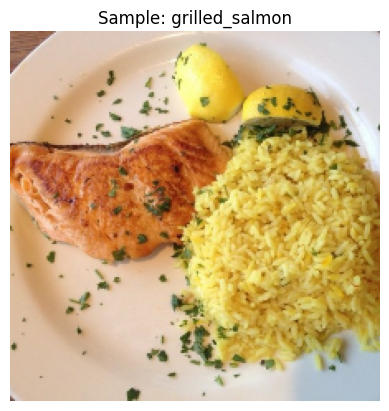

In [18]:
# Step 6

import matplotlib.pyplot as plt
import tensorflow as tf
import os

sample_rel = train_list[0]  # "class/file"
cls, fname = sample_rel.split('/')
sample_path = os.path.join(images_dir, cls, fname + '.jpg')

sample_img = decode_img_tf(sample_path)   # float32 in [0..255]
plt.imshow(sample_img.numpy() / 255.0)    # scale for display only
plt.title(f"Sample: {cls}")
plt.axis('off')
plt.show()



In [19]:
# Step 7

import numpy as np, os

def make_paths_and_labels(items):
    paths, labels = [], []
    for item in items:
        c, f = item.split('/')
        p = os.path.join(images_dir, c, f + '.jpg')
        if os.path.exists(p):
            paths.append(p); labels.append(class_to_id[c])
    return np.array(paths), np.array(labels, dtype=np.int32)

X_train, y_train = make_paths_and_labels(train_list)
X_val,   y_val   = make_paths_and_labels(val_list)
X_test,  y_test  = make_paths_and_labels(test_list)

NUM_CLASSES = len(classes)
print("Train/Val/Test:", len(X_train), len(X_val), len(X_test), "| Classes:", NUM_CLASSES)



Train/Val/Test: 68175 7575 25250 | Classes: 101


In [20]:
# Step 8

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# light aug (kept but can be disabled by commenting out)
augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p,y: (decode_img_tf(p), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(8192, seed=42)
        ds = ds.map(lambda x,y: (augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val,   y_val,   training=False).cache()
test_ds  = make_ds(X_test,  y_test,  training=False).cache()

print(train_ds, val_ds, test_ds)



<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [21]:
# Step 9

from tensorflow.keras import applications, layers, models, optimizers

inputs = layers.Input(shape=(*IMG_SIZE, 3))          # IMG_SIZE from Step 5 (224,224)
x = applications.efficientnet.preprocess_input(inputs)  # expects 0..255 floats
base = applications.EfficientNetB0(include_top=False, input_shape=(*IMG_SIZE,3), weights="imagenet")
base.trainable = False
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()




Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [22]:
# Step 10 —Run

import os, numpy as np, tensorflow as tf
from tensorflow import keras

CKPT_DIR = "checkpoints"; os.makedirs(CKPT_DIR, exist_ok=True)

IMAGES_PER_CLASS = 30      # speed knob (20–50)
EPOCHS = 2                 # keep small
MAX_TRAIN_STEPS = 60       # cap steps
MAX_VAL_STEPS   = 15

# tiny balanced subset (no heavy aug)
rng = np.random.default_rng(42)
idxs = []
for c in range(NUM_CLASSES):
    c_idx = np.where(y_train == c)[0]
    take = min(IMAGES_PER_CLASS, len(c_idx))
    idxs.append(rng.choice(c_idx, size=take, replace=False))
idxs = np.concatenate(idxs)

Xf, yf = X_train[idxs], y_train[idxs]
print(f"Training on {len(Xf)} images ({IMAGES_PER_CLASS}/class)")

train_ds_fast = (tf.data.Dataset.from_tensor_slices((Xf, yf))
                 .shuffle(4096, seed=42)
                 .map(lambda p,y: (decode_img_tf(p), y), num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))

val_ds_fast = val_ds.take(MAX_VAL_STEPS)

callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(CKPT_DIR, "best.keras"),
                                    monitor="val_accuracy", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=1, restore_best_weights=True),
]

history_quick = model.fit(
    train_ds_fast,
    validation_data=val_ds_fast,
    epochs=EPOCHS,
    steps_per_epoch=MAX_TRAIN_STEPS,
    validation_steps=MAX_VAL_STEPS,
    callbacks=callbacks,
    verbose=1
)

print("Ultra-fast run done.")




Training on 3030 images (30/class)
Epoch 1/2
48/60 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.0450 - loss: 4.4768

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.0549 - loss: 4.4224 - val_accuracy: 0.3219 - val_loss: 3.5078
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.3786 - loss: 3.1749 - val_accuracy: 0.4354 - val_loss: 2.8494
Ultra-fast run done.


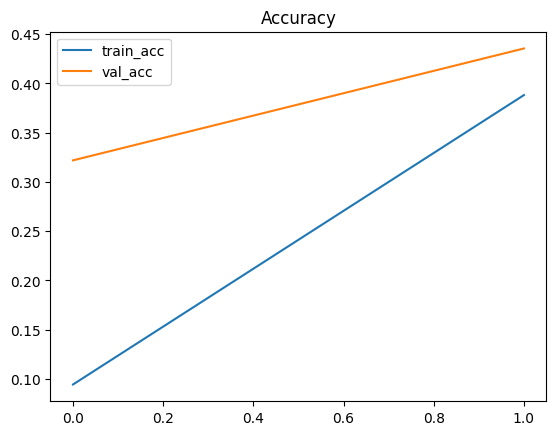

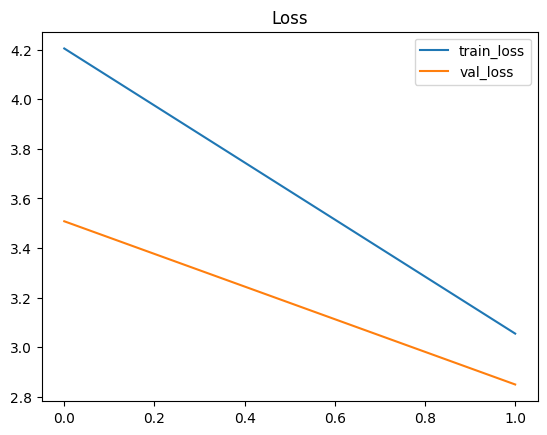

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.1309 - loss: 3.5312
[FAST] Test accuracy: 0.2172 | loss: 3.3612


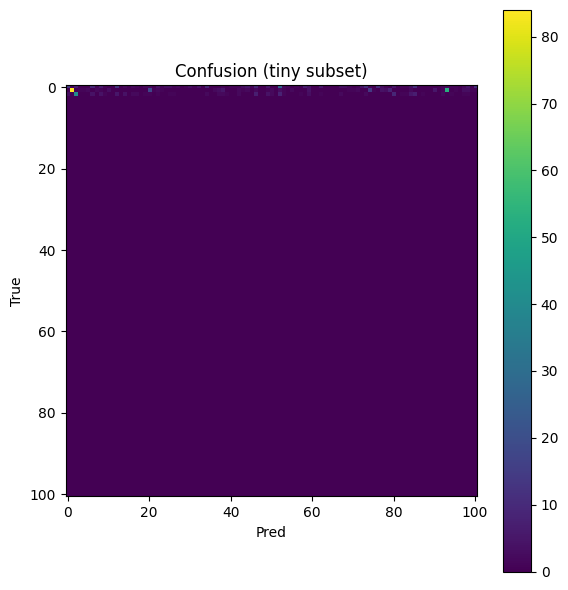

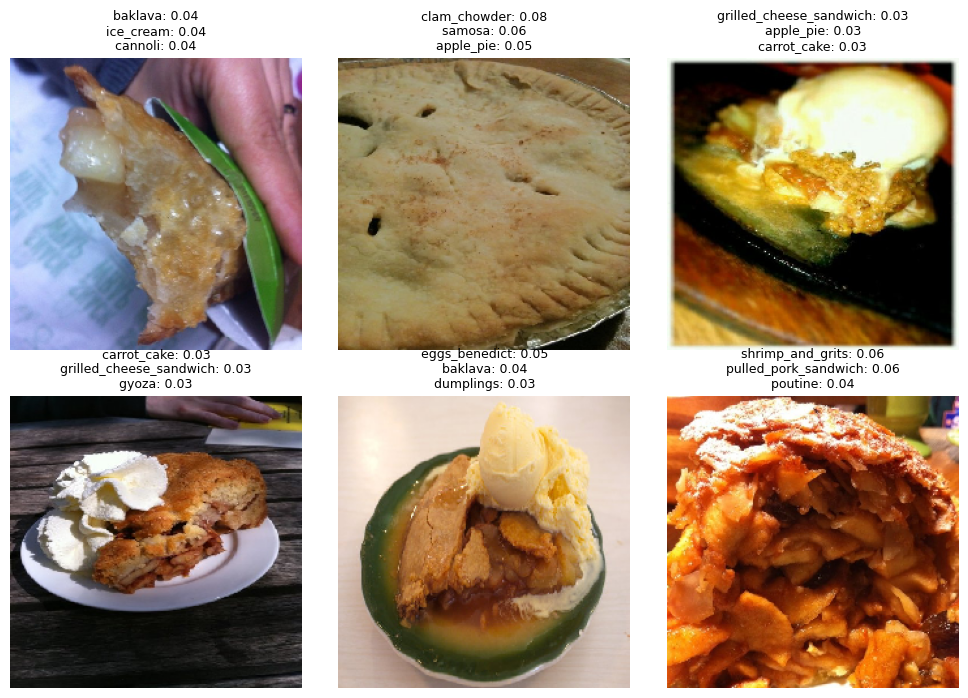

Saved to /export


In [23]:
# Step 11 — Quick evaluation, plots, predictions, save

import os, json, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras

# curves
h = history_quick
plt.figure(); plt.plot(h.history.get("accuracy", []), label="train_acc")
plt.plot(h.history.get("val_accuracy", []), label="val_acc"); plt.legend(); plt.title("Accuracy"); plt.show()
plt.figure(); plt.plot(h.history.get("loss", []), label="train_loss")
plt.plot(h.history.get("val_loss", []), label="val_loss"); plt.legend(); plt.title("Loss"); plt.show()

# fast test (capped)
MAX_TEST_STEPS = 10
test_ds_fast = test_ds.take(MAX_TEST_STEPS)
test_loss, test_acc = model.evaluate(test_ds_fast, verbose=1)
print(f"[FAST] Test accuracy: {test_acc:.4f} | loss: {test_loss:.4f}")

# tiny confusion
y_true, y_pred = [], []
for x,y in test_ds_fast:
    probs = model.predict(x, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1)); y_true.extend(y.numpy())
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(6,6)); plt.imshow(cm); plt.title("Confusion (tiny subset)")
plt.colorbar(); plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# sample predictions
def predict_image(path, top_k=3):
    img = tf.keras.utils.load_img(path, target_size=IMG_SIZE)
    arr = tf.keras.utils.img_to_array(img)              # 0..255
    arr = np.expand_dims(arr, 0)
    arr = keras.applications.efficientnet.preprocess_input(arr)
    probs = model.predict(arr, verbose=0)[0]
    idx = probs.argsort()[-top_k:][::-1]
    return [(classes[i], float(probs[i])) for i in idx]

sample_paths = X_test[:6]
plt.figure(figsize=(10,7))
for i,p in enumerate(sample_paths,1):
    plt.subplot(2,3,i)
    plt.imshow(tf.keras.utils.load_img(p, target_size=IMG_SIZE))
    t = "\n".join([f"{n}: {s:.2f}" for n,s in predict_image(p)])
    plt.title(t, fontsize=9); plt.axis('off')
plt.tight_layout(); plt.show()

# save
os.makedirs("export", exist_ok=True)
model.save("export/food101_efficientnet_fast.keras")
with open("export/labels.json","w") as f:
    json.dump({i:c for i,c in enumerate(classes)}, f)
print("Saved to /export")


In [24]:
!git clone https://github.com/Chameleon-company/MOP-Code.git
%cd MOP-Code


Cloning into 'MOP-Code'...
remote: Enumerating objects: 75503, done.
remote: Counting objects: 100% (1350/1350), done.
remote: Compressing objects: 100% (674/674), done.
remote: Total 75503 (delta 1160), reused 676 (delta 676), pack-reused 74153 (from 4)
Receiving objects: 100% (75503/75503), 5.54 GiB | 33.22 MiB/s, done.
Resolving deltas: 100% (28434/28434), done.
Updating files: 100% (28714/28714), done.
/content/MOP-Code


In [25]:
!git checkout Alen_T2_2025


Branch 'Alen_T2_2025' set up to track remote branch 'Alen_T2_2025' from 'origin'.
Switched to a new branch 'Alen_T2_2025'


In [26]:
%cd /content/MOP-Code
!git rev-parse --abbrev-ref HEAD


/content/MOP-Code
Alen_T2_2025


In [27]:
!mkdir -p "artificial-intelligence/T2_2025/Health Behaviour/Dietary monitoring/food101_alen"
TARGET_DIR="artificial-intelligence/T2_2025/Health Behaviour/Dietary monitoring/food101_alen"
